# Domain Adaptation for Aerial Imagery using Generative Adversarial Networks for Semantic Segmentation

Author: Takayuki Ota
takayuki.ota@campus.tu-berlin.de<br>
### Abstract
Segmenting aerial and satellite imagery is of great importance in many fields such as agriculture, surveillance, and city planning. With the rapid advance of deep neural networks and the rise of satellite and aerial imagery's availability, the segmenting task of aerial imagery has been intensively studied. Despite many successes of deep learning-based models, the classifier trained by data from one domain may not perform well with data from a new domain. This is called the domain adaptation problem and the main factors are various sensors, land cover, season (clear roads and covered with snow), and geography for remote sensing tasks. In this work, we deal with the domain adaptation problem of aerial imagery. We demonstrate the effectiveness of the CycleGAN-based domain adaptation method on the Inria Aerial Image Labeling Dataset, which is not tested yet to the best of our knowledge. Our method improved the segmentation performance when the model was applied to the unseen domain.


# 1. Import libraries and prepare GPU

In [1]:
!nvidia-smi
!pip install -U segmentation_models
!pip install patchify
!pip install Pillow

Tue Nov  1 18:28:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:03:00.0 Off |                    0 |
| 33%   24C    P8    16W / 260W |      0MiB / 22696MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:06:00.0 Off |                    0 |
| 33%   

In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from patchify import patchify
from PIL import Image
import tensorflow as tf
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')

from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


Segmentation Models: using `keras` framework.


In [3]:
USE_GPU = 1

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.8.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU

Visible GPU Devices:
  /physical_device:GPU:1 GPU


# 2. Preprocess images.  ※Skip to section 3 if you already have patched, ready-to-analyze data.

## 2.1 Split each image into patches

We used Inria Aerial Imagery Lebeling Dataset(https://project.inria.fr/aerialimagelabeling/)

A few sample images and labels are available at our github repository for quick test run.

The original dataset consists of 36 images and labels for each domain and there are five domains(Austin, Chicago, Kitsap, Tyrol, Vienna).

Here are some features of the dataset:

- Coverage of 810 km² (405 km² for training and 405 km² for testing)
- Aerial orthorectified color imagery with a spatial resolution of 0.3 m
- Ground truth data for two semantic classes: building and not building 


- 36 images of 5000x5000 pixel per domain
- Crop to nearest divisible by patch size(256) -> 4864x4864
- 4864/256 = 19 
- 19 * 19 = 361 patches per image
- 361 * 36 = 12996 images in total in one domain

In [ ]:
# choose patch size
PATCH_SIZE = 256
image_directory = 'master_thesis/dataset/Inria/austin/images'
patched_image_directory = "master_thesis/dataset/Inria/austin/patched_images"

label_directory = "master_thesis/dataset/Inria/austin/labels"
patched_label_directory = "master_thesis/dataset/Inria/austin/patched_labels"

In [ ]:
def make_patch(large_image, PATCH_SIZE):
    SIZE_X = (large_image.shape[1] // PATCH_SIZE) * PATCH_SIZE  # Nearest size divisible by our patch size(5888)
    SIZE_Y = (large_image.shape[0] // PATCH_SIZE) * PATCH_SIZE  # Nearest size divisible by our patch size(5888)
    image = Image.fromarray(large_image)
    image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
    image = np.array(image)
    print("Now patchifying image:",)
    patched_image = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3),step=PATCH_SIZE)  # Step=256 for 256 patches means no overlap. 23 patches of 256x256
    
    return patched_image

In [ ]:
# Split images into patches
# Uncomment cv2.imwrite if you want to save the patched images.
image_dataset = []
for path in sorted(os.listdir(image_directory)):    
    image = cv2.imread(image_directory + "/" + path, 1) # BGR, not RGB!
    if path.endswith(".png"):
        patched_image = make_patch(image, PATCH_SIZE)
        for i in range(patched_image.shape[0]):
            for j in range(patched_image.shape[1]):
                    single_patched_image = patched_image[i, j, :, :]
                    single_patched_image = single_patched_image[0]  # Drop the extra unecessary dimension that patchify adds.
                    # cv2.imwrite("master_thesis/dataset/Inria/austin/patched_images/"+ path +str(i)+ "_" + str(j)+".png", single_patched_image)
                    # print("patch_"+ path + str(i)+ "_" + str(j)+".png")
                    image_dataset.append(single_patched_image)

In [ ]:
# Apply the same processing to the label
# Split images into patches
# Uncomment cv2.imwrite if you want to save the patched images.
label_dataset = []
for path in sorted(os.listdir(label_directory)):    
    image = cv2.imread(label_directory + "/" + path, 1) # BGR, not RGB!
    if path.endswith(".png"):
        patched_image = make_patch(image, PATCH_SIZE)
        for i in range(patched_image.shape[0]):
            for j in range(patched_image.shape[1]):
                single_patched_image = patched_image[i, j, :, :]
                single_patched_image = single_patched_image[0]  # Drop the extra unecessary dimension that patchify adds.
                # cv2.imwrite("master_thesis/dataset/Inria/austin/patched_labels/"+ path +str(i)+ "_" + str(j)+".png", single_patched_image)
                # print("patch_label_"+ path +str(i)+ "_" + str(j)+".png")
                label_dataset.append(single_patched_image)

## 2.2 Split folders into train/test/validation

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders  
input_folder = 'master_thesis/dataset/Inria/austin/patched_images/'
output_folder='master_thesis/dataset/Inria/austin/patched_pipeline/'

In [ ]:
# Split with a ratio.
# Training/test/validation = 8/1/1
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1), group_prefix=None) 


Code for splitting folder into train, test, and val. Once the new folders are created, rename them and arrange in the format below to be used for semantic segmentation using data generators.


For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.
So after splitting your folders to train, val and possibly also test, rearrange them to the following format. 

Data/

    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                

    val_masks/
                val/
                    msk1, msk, msk3, ......
      
                

# 3. Build data pipeline

## 3.1 Define Generator for images and masks so we can read them directly from the drive.


In [4]:
seed=123
batch_size= 16
n_classes=1

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask= scaler.fit_transform(mask.reshape(-1, mask.shape[-1])).reshape(mask.shape)      
    
    return (img,mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

## 3.2 Declare your path here

In [17]:
from pathlib import Path

data_path = Path("master_thesis/dataset/Inria/austin/patched_pipeline/")
domain = Path("master_thesis/models/Inria/austin/")
model_name = Path("TEST-austin-Unet-50epochs-diceloss-batch16.hdf5")

train_img_path = data_path / "train_images"
train_mask_path = data_path / "train_masks"

val_img_path = data_path / "val_images"
val_mask_path = data_path / "val_masks"

train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=1)
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=1)

## 3.3 Sanity check for images and labels

Found 10396 images belonging to 2 classes.
Found 10396 images belonging to 2 classes.


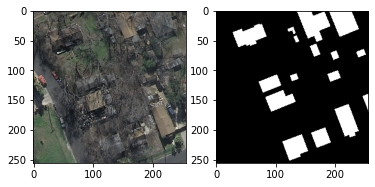

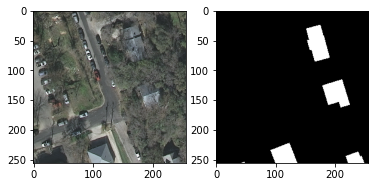

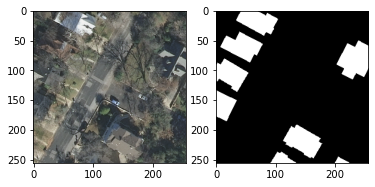

In [10]:
#Make sure the generator is working and that images and masks are indeed lined up. 
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i,:,:,]
    mask = y[i,:,:,]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

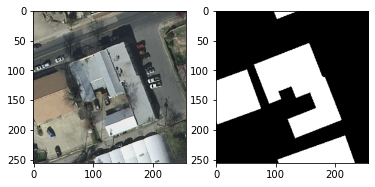

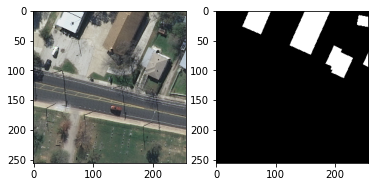

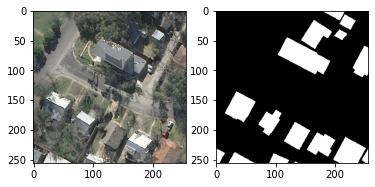

In [12]:
# apply the same sanity check for validation data
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i,:,:,]
    mask = y_val[i,:,:,]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()


# 4. Train segmentation models

## 4.1 Define the model pamaters
- model: U-Net
- loss: Dice Loss
- optimizer: Adam
- metrics: Intersection Over Union

In [13]:
num_train_imgs = len(os.listdir(train_img_path/"train/"))
num_val_images = len(os.listdir(val_img_path/"val"))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
n_classes=1
print(input_shape)

(256, 256, 3)


In [14]:
model = sm.Unet(classes=1, activation='sigmoid',input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)

dice_loss = sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer='adam',loss=dice_loss, metrics=metrics)

2022-11-01 18:29:24.647182: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 18:29:25.402766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21322 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:06:00.0, compute capability: 7.5


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [18]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir='run_logdir'),
        tf.keras.callbacks.ModelCheckpoint(domain / "checkpoint" / model_name, verbose=1, save_best_only=True)
]

## 4.2 Start training

In [19]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=2, # Change epochs if you want to train longer.
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
                 callbacks=callbacks)


Found 10396 images belonging to 2 classes.
Found 10396 images belonging to 2 classes.
Epoch 1/2


2022-11-01 18:30:38.528607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


649/649 [==============================] - ETA: 0s - loss: 0.3584 - iou_score: 0.4894 - f1-score: 0.6511Found 2600 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.

Epoch 1: val_loss improved from inf to 0.30149, saving model to master_thesis/models/Inria/austin/checkpoint/TEST-austin-Unet-50epochs-diceloss-batch16.hdf5
649/649 [==============================] - 208s 308ms/step - loss: 0.3584 - iou_score: 0.4894 - f1-score: 0.6511 - val_loss: 0.3015 - val_iou_score: 0.5403 - val_f1-score: 0.6993
Epoch 2/2
649/649 [==============================] - ETA: 0s - loss: 0.2613 - iou_score: 0.5891 - f1-score: 0.7393
Epoch 2: val_loss improved from 0.30149 to 0.24736, saving model to master_thesis/models/Inria/austin/checkpoint/TEST-austin-Unet-50epochs-diceloss-batch16.hdf5
649/649 [==============================] - 195s 295ms/step - loss: 0.2613 - iou_score: 0.5891 - f1-score: 0.7393 - val_loss: 0.2474 - val_iou_score: 0.6060 - val_f1-score: 0.7530


## 4.3 Plot the loss and IoU curve

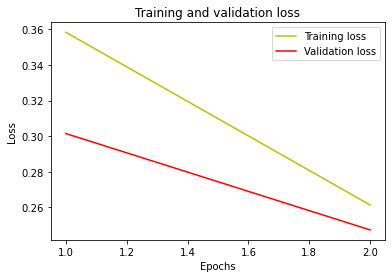

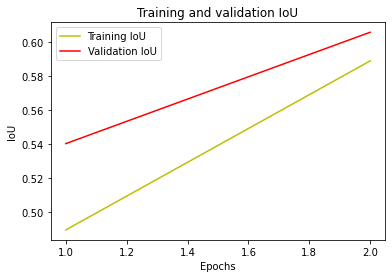

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('master_thesis/training_logs/UNet-chicago-50epochs-16batches-diceloss-loss.png')
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
# plt.savefig('master_thesis/training_logs/UNet-chicago-50epochs-16batches-diceloss-iou.png')

plt.show()

## 4.4 View a few images, masks, and predictions

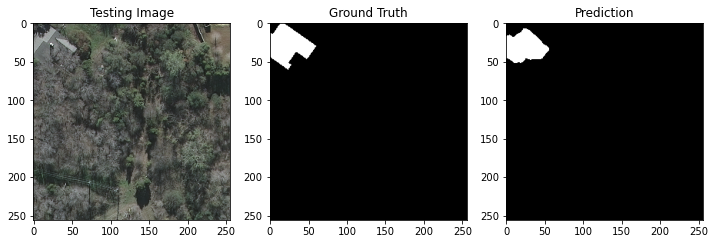

In [21]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
img_num = random.randint(0, test_image_batch.shape[0]-1)

prediction = (model.predict(test_image_batch)[img_num] > 0.5).astype(np.uint8)
prediction = prediction[:,:,0]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(test_mask_batch[img_num],cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction,cmap='gray')
# plt.savefig('master_thesis/predictions/chicago/UNet-chicago-50epochs-16batches-diceloss-prediction-9.png')

plt.show()

## 4.5 Save the model

In [ ]:
# model.save(domain / model_name)
# model.save('master_thesis/models/Inria/alldomain/Unet-50epochs-diceloss-batch16-sm.hdf5')

# 5. Evaluate the model

## 5.1 Load models

In [22]:
from keras.models import load_model
import segmentation_models as sm
sm.set_framework('tf.keras')

# restored_model = model
restored_model = load_model("master_thesis/models/Inria/austin/viennastyled-Unet-50epochs-diceloss-batch16.hdf5", compile=False)
# restored_naive_model = load_model("master_thesis/models/Inria/austin/Unet-50epochs-diceloss-batch16-sm.hdf5", compile=False)
# restored_model_chicago = load_model("master_thesis/models/Inria/austin/chicagostyled-Unet-50epochs-diceloss-batch16.hdf5", compile=False)
# restored_model_kitsap = load_model("master_thesis/models/Inria/vienna/kitsapstyled-Unet-50epochs-diceloss-batch16.hdf5", compile=False)
# restored_model_tyrol = load_model("master_thesis/models/Inria/vienna/tyrolstyled-Unet-50epochs-diceloss-batch16.hdf5", compile=False)
# restored_model_vienna = load_model("master_thesis/models/Inria/vienna/viennastyled-Unet-50epochs-diceloss-batch16.hdf5", compile=False)

dice_loss = sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

restored_model.compile(optimizer='adam',loss=dice_loss, metrics=metrics)
# restored_naive_model.compile(optimizer='adam',loss=dice_loss, metrics=metrics)
# restored_model_chicago.compile(optimizer='adam',loss=dice_loss, metrics=metrics)
# restored_model_kitsap.compile(optimizer='adam',loss=dice_loss, metrics=metrics)
# restored_model_tyrol.compile(optimizer='adam',loss=dice_loss, metrics=metrics)
# restored_model_vienna.compile(optimizer='adam',loss=dice_loss, metrics=metrics)

## 5.2 Evaluate on test data

In [ ]:
results = restored_model.evaluate(val_img_gen, steps=100)
# results_naive = restored_naive_model.evaluate(val_img_gen, steps=100)
# results_chicago = restored_model_chicago.evaluate(val_img_gen, steps=100)
# results_kitsap = restored_model_kitsap.evaluate(val_img_gen, steps=100)
# results_tyrol = restored_model_tyrol.evaluate(val_img_gen, steps=100)
# results_vienna = restored_model_vienna.evaluate(val_img_gen, steps=100)


 46/100 [============>.................] - ETA: 12s - loss: 0.1300 - iou_score: 0.7712 - f1-score: 0.8700

# 6. Train CycleGAN to translate the style of image

Implementation of this part is based on the officidal code repository of the O'Reilly book 'Generative Deep Learning'
https://github.com/davidADSP/GDL_code/tree/tensorflow_2

In [ ]:
!pip install tensorflow-addons
!pip install pydot
!pip install graphviz
%load_ext autoreload
%autoreload 2

In [ ]:
from models.cycleGAN import CycleGAN
from utils.loaders import DataLoader

## 6.1 Set up parameters

Folder structure needs to be like below:

data/
     
     austin2chicago/
    
        trainA/
            img1, img2, img3 ...
        testA/
            img11, img12, img13 ...
        trainB/
            img1, img2, img3 ...
        testB/
            img11, img12, img13 ...

For example, you can prepare training data for austin2chicago translation with this command.

cp -a dataset/Inria/austin/patched_pipeline/train_images/train/. GDL_code/data/austin2chicago/trainA

cp -a dataset/Inria/chicago/patched_pipeline/train_images/train/. GDL_code/data/austin2chicago/trainB

In [ ]:
SECTION = 'cyclegan'
RUN_ID = '0005'
DATA_NAME = 'austin2chicago'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

# choose each one test image for domain A and B. It will be used for plotting the progress of training
TEST_A_FILE = "austin1.png0_0.png"
TEST_B_FILE = "chicago1.png0_1.png"

IMAGE_SIZE = 256
BATCH_SIZE = 1 #default = 1
EPOCHS = 15 # default = 200
PRINT_EVERY_N_BATCHES = 1000

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build'

In [ ]:
data_loader = DataLoader(dataset_name=DATA_NAME, img_res=(IMAGE_SIZE, IMAGE_SIZE))

## 6.2 cycleGAN architecture
validation, reconstr, id are the parameters for three loss functions. Play around with them. Defalult is validation=1,reconstr=10,id=2 


In [ ]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
    ,learning_rate = 0.0002
    , buffer_max_length = 50
    , lambda_validation = 1
    , lambda_reconstr = 10
    , lambda_id = 2
    , generator_type = 'unet'
    , gen_n_filters = 32
    , disc_n_filters = 32
    )
if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
    print("Model" + RUN_FOLDER+ " is loaded.")

In [ ]:
gan.g_AB.summary()
# gan.g_BA.summary()
# gan.d_A.summary()
# gan.d_B.summary()

In [ ]:
history = gan.train(data_loader
        , run_folder = RUN_FOLDER
        , epochs=EPOCHS
        , test_A_file = TEST_A_FILE
        , test_B_file = TEST_B_FILE
        , batch_size=BATCH_SIZE
        , sample_interval=PRINT_EVERY_N_BATCHES)

In [ ]:
fig = plt.figure(figsize=(20,10))

plt.plot([x[1] for x in gan.g_losses], color='green', linewidth=0.5) #DISCRIM LOSS
# plt.plot([x[2] for x in gan.g_losses], color='orange', linewidth=0.1)
plt.plot([x[3] for x in gan.g_losses], color='blue', linewidth=0.5) #CYCLE LOSS
# plt.plot([x[4] for x in gan.g_losses], color='orange', linewidth=0.25)
plt.plot([x[5] for x in gan.g_losses], color='red', linewidth=0.5) #ID LOSS
# plt.plot([x[6] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.plot([x[0] for x in gan.g_losses], color='black', linewidth=0.25)

# plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=1)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.ylim(0, 5)

plt.show()

## 6.3 Translate the images using trained cycleGAN model

In [ ]:
import tqdm
import time

source_images_dir = "data/austin2chicago/trainA"
translated_images_dir = "data/austin2chicago/fakeB"
image_dataset = []
fake_dataset = []

for path in tqdm.tqdm(sorted(os.listdir(source_images_dir))):    
    if path.endswith(".png"):
        # print(path)
        image = cv2.imread(source_images_dir+ "/" + path, 1)
        image = np.expand_dims(image, axis=0)
        fake_B = gan.g_AB.predict(image)     
        fake_B = fake_B[0]  # Drop the extra unecessary dimension
        fake_B = Image.fromarray(((fake_B-fake_B.min())/(fake_B.max()-fake_B.min())*255).astype(np.uint8), 'RGB') # reverse the normalized data(-1~+1) to 0-255
        fake_B.save(translated_images_dir + "/fake_" + path)
        fake_dataset.append(fake_B)
        image_dataset.append(image)

In [ ]:
# You can also translate from domain B to A
source_images_dir = "data/austin2chicago/trainB"
translated_images_dir = "data/austin2chicago/fakeA"
image_dataset = []
fake_dataset = []
for path in tqdm.tqdm(sorted(os.listdir(source_images_dir))):    
    if path.endswith(".png"):
        # print(path)
        image = cv2.imread(source_images_dir+ "/" + path, 1)
        image = np.expand_dims(image, axis=0)
        fake_A = gan.g_BA.predict(image)
        fake_A = fake_A[0]  # Drop the extra unecessary dimension
        fake_A = Image.fromarray(((fake_A-fake_A.min())/(fake_A.max()-fake_A.min())*255).astype(np.uint8), 'RGB') # reverse the normalized data(-1~+1) to 0-255
        fake_A.save(translated_images_dir + "/fake_" + path)
        fake_dataset.append(fake_A)
        image_dataset.append(image)

## 5.4 Go to step 3. and train the model using translated data

In [8]:
cd ..

/home/jovyan
